In [1]:
from emulator_utils.pre_process import log_standard, minmax, standard_minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp, mcdrop_pred

In [2]:
import matplotlib.pylab as plt
import numpy as np

In [3]:
# dirIn = '../test/data/sps_ugrizy/'
dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/'

# mags = np.load(dirIn + 'colors.npy')
mags = np.load(dirIn + 'spec.npy')

ebv = np.load(dirIn + 'ebv.npy')
redshift = np.load(dirIn + 'redshift.npy')
sfh = np.load(dirIn + 'sfh.npy')

In [4]:
sps_inputs = np.concatenate((redshift[np.newaxis, :], ebv[np.newaxis, :], sfh.T), axis=0).T

In [5]:
scaled, scaler = standard_minmax(sps_inputs)

In [6]:
scaled_y, scaler_y = log_standard(mags)

In [7]:
param_train, param_test, mag_train, mag_test = random_holdout(scaled, scaled_y, split_fraction = 0.1)

In [8]:
param_train.shape, mag_train.shape

((9000, 180), (9000, 1963))

In [9]:
mlp = simple_mlp(input_shape=param_train.shape[1], 
                 output_shape=mag_train.shape[1], 
                 hidden_dims=[512, 512, 1024, 1024, 2048, 2048, 1024, 1024])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               92672     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1

### Setting Hyper-parameters

In [10]:
learning_rate = 1e-3
decay_rate = 0.0
batch_size = 128
num_epochs = 100

In [11]:
mlp, train_history = train_mlp(mlp, 
                    # param_train, pk_train, param_test, pk_test, 
                    param_train, mag_train, param_test, mag_test,
                    learning_rate, decay_rate, num_epochs, batch_size);

Training complete
Test loss after training: 0.078


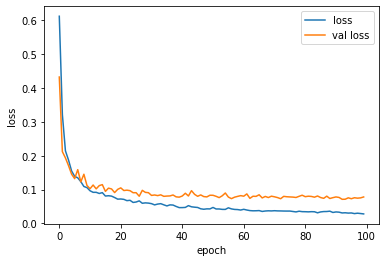

In [12]:
plt.figure(2111)
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [13]:
save_mlp(mlp, '../test/model/spec_mlp')
mlp = load_mlp('../test/model/spec_mlp')

2022-04-27 00:43:48.162066: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../test/model/spec_mlp/assets
Model saved at../test/model/spec_mlp


In [14]:
def mag_forward(param_in):
    redshift_in = param_in[:, 0]
    ebv_in = param_in[:, 1]

    sfh_in = sfh[10][np.newaxis, :]
    sfh_in = np.tile(sfh_in, (ebv_in.shape[0], 1))

    input_params = np.concatenate( (redshift_in.reshape(-1, 1), 
                                    ebv_in.reshape(-1, 1), 
                                    sfh_in) , axis=1)

    sps_in = scaler.transform(input_params)

    mlp_pred = mlp.predict(sps_in)
    mags_pred = unscale(mlp_pred, scaler_y)

    
    return mags_pred

In [15]:
def prob_color(param_in):
    
    '''
    This provides p(colors|redshift, dust). But SFH is chosen (arbitrarily). 
    
    '''
    
    redshift_in = param_in[:, 0]
    ebv_in = param_in[:, 1]
    
    
    sfh_id = 320
    sfh_in = sfh[sfh_id][np.newaxis, :]
    sfh_in = np.tile(sfh_in, (ebv_in.shape[0], 1))

    input_params = np.concatenate( (redshift_in.reshape(-1, 1), 
                                    ebv_in.reshape(-1, 1), 
                                    sfh_in) , axis=1)

    sps_in = scaler.transform(input_params)
  
    #############    
    mags_pred, _, _ = mcdrop_pred(mlp, sps_in, scaler_y)    
    return mags_pred


def prob_color_all(param_in):
    
    '''
    This provides p(colors|redshift, dust, SFH).
    
    '''
    
    sps_in = scaler.transform(param_in)
    mags_pred, _, _ = mcdrop_pred(mlp, sps_in, scaler_y) 
    return mags_pred
    

In [16]:
param_test_unscaled = unscale(param_test, scaler)
mlp_pred = mlp.predict(param_test_unscaled)  
color_pred = unscale(mlp_pred, scaler_y)

overflow encountered in power


In [17]:
param_train_unscaled = unscale(param_train, scaler)
param_test_unscaled = unscale(param_test, scaler)

# pcolor = prob_color(param_test_unscaled) ## wrong SFH
mean_color = mag_forward(param_test_unscaled) ## wrong SFH

pcolor_all = prob_color_all(param_test_unscaled)

(1.0, 100000000.0)

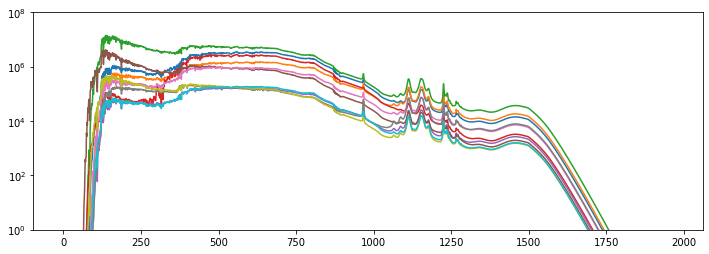

In [18]:
plt.figure(figsize = (12, 4))
plt.plot(unscale(mag_test, scaler_y)[0:10].T, label='truth');
plt.yscale('log')
plt.ylim(1e0, 1e8)

(100.0, 20000000.0)

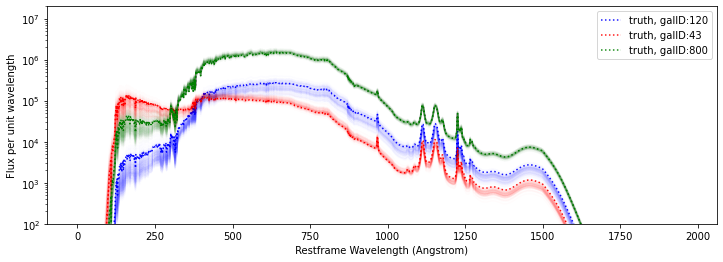

In [25]:
plt.figure(figsize = (12, 4))
color_arr = ['blue', 'red', 'green']

indx = -1
for galID in [120, 43, 800]:
    indx +=1

    # plt.plot(color_pred[galID], label='pred')
    # plt.plot(mean_color[galID], label='pred0')
    plt.plot(unscale(mag_test, scaler_y)[galID], linestyle='dotted', color = color_arr[indx], label='truth, galID:%d'%galID, alpha=0.9)
    # plt.plot(pcolor[:, galID, :].T,  color = color_arr[indx], alpha=0.01)
    plt.plot(pcolor_all[:, galID, :].T,  color = color_arr[indx], alpha=0.01)


plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
plt.legend()
plt.ylim(1e2, 2e7)
# plt.xlim(50, 1700)

(10.0, 100000000.0)

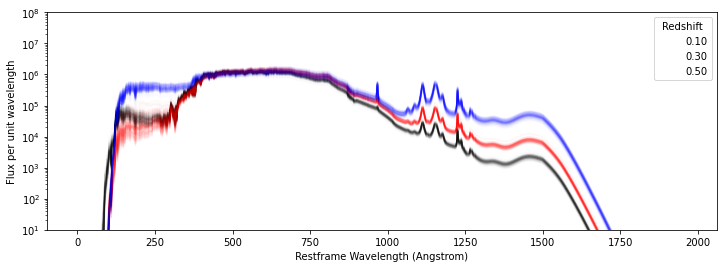

In [20]:
#### redshift variation
color_arr = ['k', 'red', 'blue', 'violet', 'k', 'orange']

plt.figure(figsize = (12, 4))

dust_in = 0.04
redshift_in_array = [0.1, 0.3, 0.5]

indx = -1
for redshift_in in redshift_in_array:
    indx+=1

    pcolor = prob_color( np.array([redshift_in, dust_in])[np.newaxis, :]) ## wrong SFH
    plt.plot( np.mean(pcolor[:, 0, :].T, axis=1),  color = color_arr[indx], alpha=0, label='%.2f'%redshift_in);
    plt.plot( pcolor[:, 0, :].T,  color = color_arr[indx], alpha=0.02);

    
plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
plt.legend(title='Redshift')
plt.ylim(1e1, 1e8)

(10.0, 100000000.0)

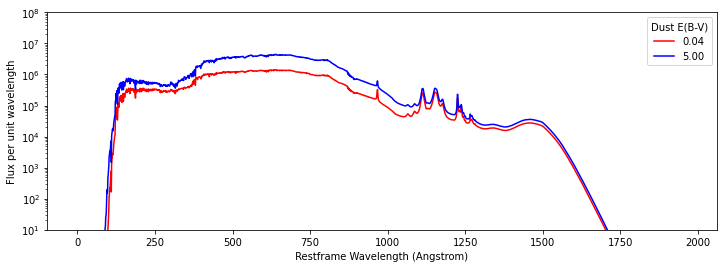

In [21]:
#### dust variation
color_arr = ['k', 'red', 'blue', 'violet', 'k', 'orange']

plt.figure(figsize = (12, 4))

dust_in_array = [0.04, 5.0]
redshift_in = 0.4

indx = 0
for dust_in in dust_in_array:
    indx+=1

    pcolor = prob_color( np.array([redshift_in, dust_in])[np.newaxis, :]) ## wrong SFH
    plt.plot( np.mean(pcolor[:, 0, :].T, axis=1),  color = color_arr[indx], alpha=1, label='%.2f'%dust_in);
    
plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
plt.legend(title='Dust E(B-V)')
plt.ylim(1e1, 1e8)

In [22]:
%timeit unscale(mag_test, scaler_y)[galID]

37.4 ms ± 82.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
